In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

In [2]:
colnames=['date', 'time','destination','student_id', 'cohort',
          'ip' ]
df = pd.read_csv('curriculum-access.txt', engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 1, 2, 3, 4, 5, 6])

In [3]:
df

,date,time,destination,student_id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62
...,...,...,...,...,...,...
543591,2020-05-15,15:01:40,java-ii/file-io,602,56.0,48.188.241.68
543592,2020-05-15,15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38
543593,2020-05-15,15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17
543594,2020-05-15,15:05:14,10-anomaly-detection/3-discrete-probabilistic-...,11,28.0,77.186.132.227


In [4]:
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'] = pd.to_datetime(df.datetime)
df = df.drop(columns = ['date', 'time'])
df = df.set_index('datetime')
df.head()

,destination,student_id,cohort,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [46]:
curie = df[df.cohort == 55]

In [49]:
curie['count'] = 1

In [51]:
curie_n = curie['count'].resample('1D').sum()

In [52]:
curie_n

datetime
2020-02-03    125
2020-02-04    237
2020-02-05    424
2020-02-06    720
2020-02-07    413
             ... 
2020-05-11    139
2020-05-12     96
2020-05-13     74
2020-05-14     99
2020-05-15     95
Freq: D, Name: count, Length: 103, dtype: int64

In [53]:
span = 7
ema_long = curie_n.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*6
lb = midband - ema_long[-24:-1].std()*6

In [54]:
ub, lb

(271.0872584175518, -83.26321498948522)

In [55]:
midband

93.9120217140333

In [56]:
pct_b = pd.DataFrame({'pct_b': (curie_n-lb)/(ub-lb)})
curie_n= pd.DataFrame(curie_n)

In [57]:
curie_n = pd.concat([curie_n, pct_b], axis=1)


In [58]:
curie_n

,count,pct_b
datetime,,
2020-02-03,125,0.587732
2020-02-04,237,0.903804
2020-02-05,424,1.431530
2020-02-06,720,2.266861
2020-02-07,413,1.400487
...,...,...
2020-05-11,139,0.627241
2020-05-12,96,0.505892
2020-05-13,74,0.443807


In [59]:
curie_n[curie_n.pct_b >1]

,count,pct_b
datetime,,
2020-02-05,424,1.431530
2020-02-06,720,2.266861
2020-02-07,413,1.400487
2020-02-10,350,1.222697
2020-02-11,272,1.002576
2020-03-09,339,1.191654
2020-03-10,307,1.101348
2020-03-11,311,1.112636
2020-04-08,282,1.030796


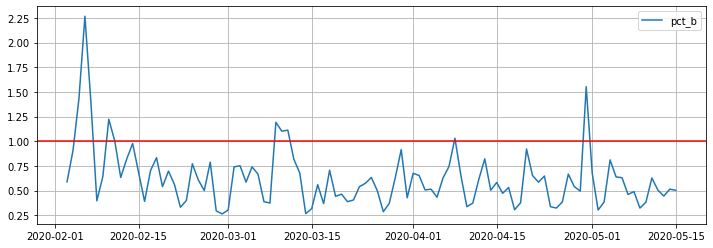

In [60]:
plt.figure(figsize=(12,4))
plt.plot(curie_n.pct_b, label = 'pct_b')
plt.grid()
plt.axhline(y=1.0, color='r', linestyle='-')
plt.legend()

### Curie students were studying really hard on April 30th for quiz!!

****

In [73]:
page_view = curie.groupby('destination').count()

In [71]:
page_view = page_view.to_dict()

In [72]:
page_view

{'student_id': {'%20https://github.com/RaulCPena': 1,
  ',%20https://github.com/RaulCPena': 1,
  '/': 865,
  '1-fundamentals/1.1-intro-to-data-science': 405,
  '1-fundamentals/1.2-data-science-pipeline': 119,
  '1-fundamentals/1.3-pipeline-demo': 51,
  '1-fundamentals/2.1-excel-overview': 46,
  '1-fundamentals/2.1-spreadsheets-overview': 73,
  '1-fundamentals/2.2-excel-functions': 27,
  '1-fundamentals/2.2-functions': 90,
  '1-fundamentals/2.3-visualization': 2,
  '1-fundamentals/2.3-visualization-with-excel': 87,
  '1-fundamentals/2.3-visualization.md': 2,
  '1-fundamentals/2.4-more-excel-features': 16,
  '1-fundamentals/3-vocabulary': 52,
  '1-fundamentals/AI-ML-DL-timeline.jpg': 408,
  '1-fundamentals/DataToAction_v2.jpg': 122,
  '1-fundamentals/modern-data-scientist.jpg': 410,
  '10-anomaly-detection/1-overview': 88,
  '10-anomaly-detection/2-continuous-probabilistic-methods': 1,
  '10-anomaly-detection/4-detecting-timeseries-anomalies': 2,
  '10-anomaly-detection/5-detecting-with-

In [79]:
curie['views'] = curie['destination'].map(page_view['student_id'])

In [83]:
curie.sort_values('views', ascending = False)

,destination,student_id,cohort,ip,count,views
datetime,,,,,,
2020-02-07 08:21:32,/,584,55.0,98.106.20.59,1,865.0
2020-05-01 15:33:42,/,579,55.0,137.51.65.246,1,865.0
2020-03-04 20:09:29,/,587,55.0,65.251.10.182,1,865.0
2020-04-13 09:06:32,/,583,55.0,46.28.10.172,1,865.0
2020-02-24 14:36:40,/,591,55.0,98.106.20.59,1,865.0
...,...,...,...,...,...,...
2020-02-21 13:26:48,11-nlp/6-model,577,55.0,98.106.20.59,1,1.0
2020-04-13 12:09:28,10-anomaly-detection/5-detecting-with-clustering,581,55.0,73.191.188.174,1,1.0
2020-02-19 11:38:00,4-python/7.5-intro-to-seaborn,579,55.0,98.106.20.59,1,1.0


In [88]:
top_10 = curie.groupby('destination').count().sort_values('count', ascending = False).iloc[0:11]

In [90]:
top_10

,student_id,cohort,ip,count,views
destination,,,,,
/,865,865,865,865,865
6-regression/1-overview,446,446,446,446,446
1-fundamentals/modern-data-scientist.jpg,410,410,410,410,410
1-fundamentals/AI-ML-DL-timeline.jpg,408,408,408,408,408
1-fundamentals/1.1-intro-to-data-science,405,405,405,405,405
3-sql/1-mysql-overview,365,365,365,365,365
search/search_index.json,307,307,307,307,307
4-python/8.4.3-dataframes,255,255,255,255,255
4-python/8.4.4-advanced-dataframes,234,234,234,234,234


In [ ]:
df.loc['2019-04-04': '2019-06-30'][pd.df.cohort.isna == True]

In [129]:
ada = df[pd.isna(df.cohort) == True].loc['2019-02-03': '2019-06-30']

In [130]:
ada.student_id.unique()

array([349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369,  58,  54, 372, 375,  48,
        88,  63, 403, 166, 406, 429])

In [131]:
ada

,destination,student_id,cohort,ip
datetime,,,,
2019-02-04 16:22:20,/,349,NaN,98.106.20.59
2019-02-04 16:22:36,/,350,NaN,98.106.20.59
2019-02-04 16:23:07,1._Fundamentals,350,NaN,98.106.20.59
2019-02-04 16:23:34,/,351,NaN,98.106.20.59
2019-02-04 16:36:36,/,352,NaN,98.106.20.59
...,...,...,...,...
2019-06-30 13:42:10,9.2_Detect_through_Probability,349,NaN,25.161.140.9
2019-06-30 13:56:07,3.0-mysql-overview,429,NaN,69.202.220.224
2019-06-30 13:56:09,4.2_data_types_and_variables,429,NaN,69.202.220.224


In [183]:
ada_list = pd.Series([349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369,  372])

In [185]:
ada = df[df['student_id'].isin(ada_list)]

In [190]:
ada.loc['2019-12-01': '2020-05-15']

,destination,student_id,cohort,ip
datetime,,,,
2019-12-01 19:55:39,/,362,NaN,71.124.194.101
2019-12-02 13:08:43,/,352,NaN,105.192.14.220
2019-12-02 13:08:47,1-fundamentals/1.2-data-science-pipeline,352,NaN,105.192.14.220
2019-12-02 13:08:47,1-fundamentals/DataToAction_v2.jpg,352,NaN,105.192.14.220
2019-12-02 13:56:23,1-fundamentals/1.3-pipeline-demo,352,NaN,105.192.14.220
...,...,...,...,...
2020-05-13 16:30:22,8-clustering/project,349,NaN,157.81.5.3
2020-05-13 16:30:38,8-clustering/5-model,349,NaN,157.81.5.3
2020-05-13 17:36:13,/,366,NaN,100.89.63.138


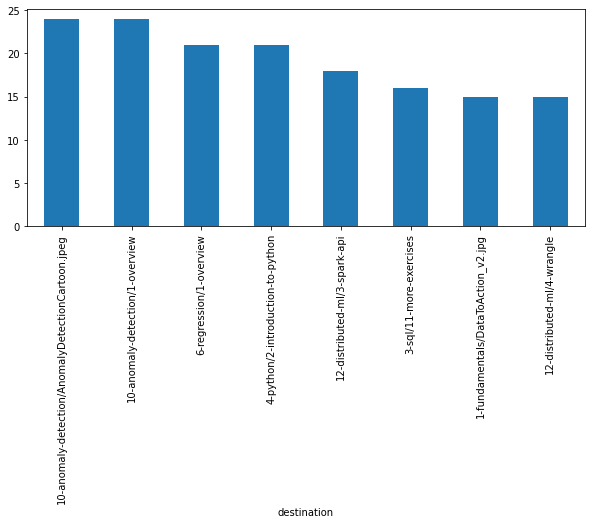

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabels'

In [215]:
ada.loc['2019-12-01': '2020-05-15'].groupby('destination').count().sort_values('student_id', ascending = False).rename(columns = {'student_id': 'view_count'}).iloc[2:10].view_count.plot.bar(figsize=(10,4))
plt.show()
plt.xlabels(rotation =45)